In [2]:
from importlib import reload
import os
from time import time
import copy

import sys
sys.path.append('/homefs/home/wongfanc/density-ratio-estimation/')

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.decomposition import PCA
import random

import torch
print(torch.cuda.is_available())

import pprint
import editdistance

import utils
import tdre
import shifts
import designdata as dd
import calibrate as cal

import flexs
import flexs.utils.sequence_utils as s_utils

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

True


<IPython.core.display.Javascript object>

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(
    physical_devices[0], True
)

# KDE

In [16]:
from sklearn.neighbors import KernelDensity

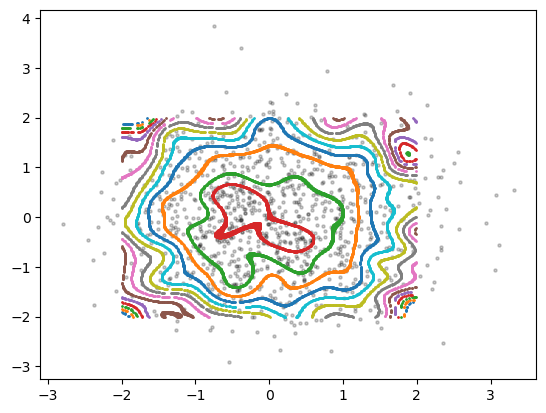

In [31]:
# visualize contours
data = np.random.randn(1000, 2)
plt.scatter(data[:, 0], data[:, 1], color='k', alpha=0.2, s=5);

kde = KernelDensity(bandwidth=0.2)
kde.fit(data)
x
x, y = np.mgrid[-2:2:0.01, -2:2:0.01]
grid = np.hstack([x.ravel()[:, None], y.ravel()[:, None]])
gridll = kde.score_samples(grid)

for val in np.arange(-6, -2, 0.3):
    idx = np.where(np.abs(gridll - val) < 0.01)
    plt.scatter(grid[idx, 0], grid[idx, 1], s=1)

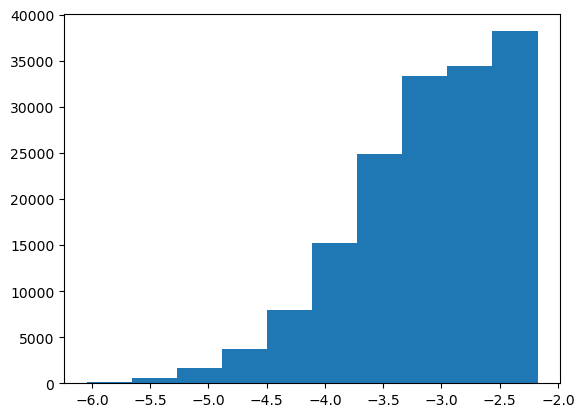

In [23]:
plt.hist(gridll);

# try out predictive models

(array([77., 13.,  5.,  0.,  1.,  0.,  2.,  1.,  0.,  1.]),
 array([1.43249452, 1.61594447, 1.79939442, 1.98284436, 2.16629431,
        2.34974426, 2.53319421, 2.71664416, 2.9000941 , 3.08354405,
        3.266994  ]),
 <BarContainer object of 10 artists>)

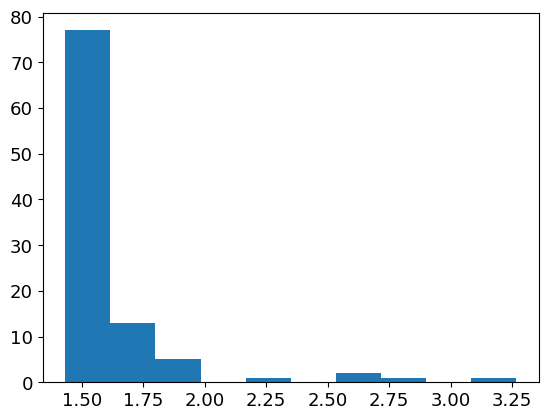

In [16]:
plt.hist(gfp_landscape.get_fitness(trainseqs_n[: 100]))

/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Generating 2000 labeled training and calibration data...
Done. (6 s)


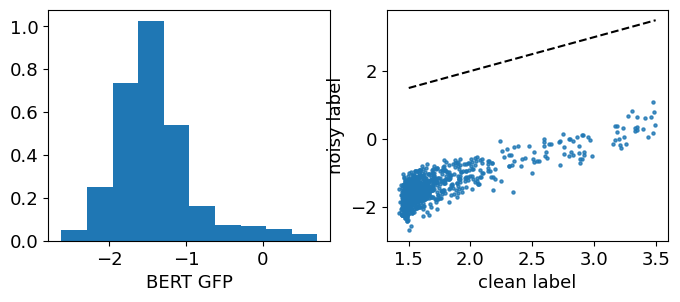

In [43]:
# generate training data
n = 2000
n_cal = 1000
avg_n_mut = 10
noise_sd = 0
c = 0.1

gfp_landscape = flexs.landscapes.BertGFPBrightness()
seed = gfp_landscape.starts['ed_18_wt']

p_mut = avg_n_mut / 238
trainseqs_n = [dd.get_mutant(seed, p_mut, s_utils.AAS) for _ in range(n)]
print('Generating {} labeled training and calibration data...'.format(n))
t0 = time()
ytrain_n = gfp_landscape.get_fitness(trainseqs_n)

# generate noise
# noise_n = sc.stats.norm.rvs(loc=0, scale=noise_sd, size=len(trainseqs_n))
# noise_n = np.array([sc.stats.norm.rvs(loc=0, scale=noise_sd / y) for y in ytrain_n])
# RMF
noise_n = -np.array([c * editdistance.eval(seq, gfp_landscape.gfp_wt_sequence) for seq in trainseqs_n])
ytrain_n = ytrain_n + noise_n
print('Done. ({} s)'.format(int(time() - t0)))

trainseqs_n, calseqs_n = trainseqs_n[: n - n_cal], trainseqs_n[n - n_cal :]
ytrain_n, ycal_n = ytrain_n[: n - n_cal], ytrain_n[n - n_cal :]

plt.figure(figsize=(8, 3));
plt.subplot(121)
plt.hist(ycal_n, density=True);
plt.xlabel('BERT GFP');

plt.subplot(122)
plt.plot([1.5, 3.5], [1.5, 3.5], '--k');
plt.scatter(ytrain_n - noise_n[: n - n_cal], ytrain_n, s=5, alpha=0.8);
plt.xlabel('clean label');
plt.ylabel('noisy label');

In [44]:
# model_class = flexs.baselines.models.RidgeCV
# model_kwargs = {
#     'alphas': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
# }

# model_class = flexs.baselines.models.MLP
# model_kwargs = {
#     'hidden_size': 16,
#     'loss': 'MSE',
#     'batch_size': 10,
#     'epochs': 5
# }

model_class = flexs.baselines.models.CNN
model_kwargs = {
    'num_filters': 64,
    'hidden_size': 64,
    'loss': 'MSE',
    'batch_size': 10,
    'epochs': 5
}

print('Training...')
t0 = time()
model = flexs.Ensemble([
    model_class(len(trainseqs_n[0]), alphabet=s_utils.AAS, **model_kwargs)
    for i in range(3)
])
# ridge doesn't need length
# model = model_class(alphabet=s_utils.AAS, **model_kwargs)
model.train(trainseqs_n, ytrain_n) # , verbose=True)
print('Done. ({} s)'.format(int(time() - t0)))
# print(model.models[0].model.summary())

Training...
Done. (9 s)


100/100 [==============================] - 0s 1ms/step


/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


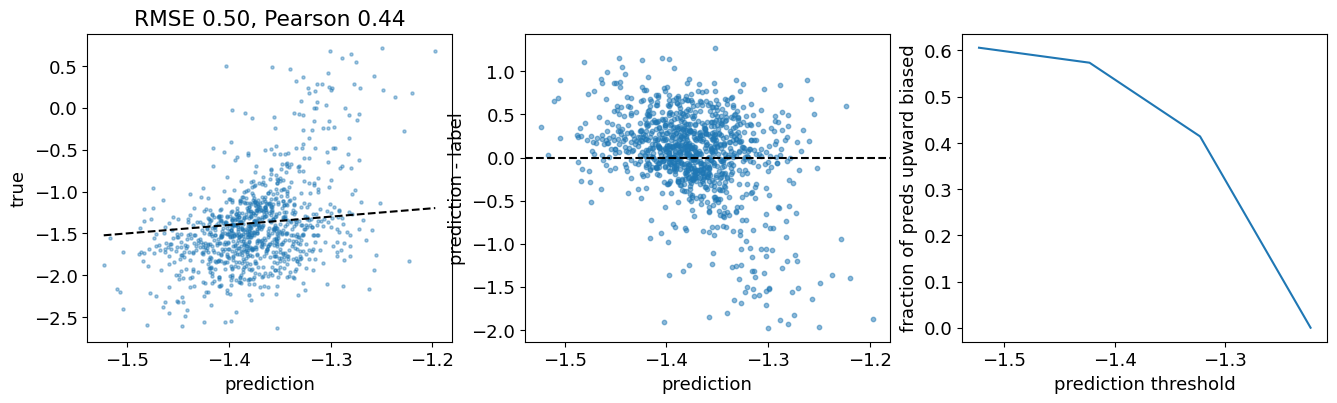

In [45]:
plt.figure(figsize=(16, 4))

predcal_n = model.get_fitness(calseqs_n)
xy_lim = [np.min(predcal_n), np.max(predcal_n)]

rmse = np.sqrt(np.mean(np.square(predcal_n - ycal_n)))
r, p = sc.stats.pearsonr(predcal_n, ycal_n)

plt.subplot(131)
plt.scatter(predcal_n, ycal_n, alpha=0.4, s=5)
plt.xlabel('prediction'); plt.ylabel('true'); 
plt.plot(xy_lim, xy_lim, '--k');
plt.title('RMSE {:.2f}, Pearson {:.2f}'.format(rmse, r));

threshs = np.arange(np.min(predcal_n), np.max(predcal_n) + 0.1, 0.1)
res_n = predcal_n - ycal_n

plt.subplot(132)
plt.scatter(predcal_n, res_n, s=10, alpha=0.5);
plt.axhline(0, linestyle='--', color='k');
plt.ylabel('prediction - label'); plt.xlabel('prediction');

frac_up_bias = [np.mean(res_n[np.where(predcal_n >= thresh)[0]] > 0) for thresh in threshs]
plt.subplot(133)
plt.plot(threshs, frac_up_bias);
plt.xlabel('prediction threshold');
plt.ylabel('fraction of preds upward biased');

# run design

In [47]:
reload(dd)

landscape_name = 'gfp'
n = 2000
N = 1000
n_mut = 10
heteroskedastic = True
noise_sd = 0
c = 0.1
n_trial = 1

model_name = 'cnn'
model_kwargs = {
    'num_filters': 64,
    'hidden_size': 64,
    'loss': 'MSE',
    'batch_size': 10,
    'epochs': 5,
}
# model_name = 'ff'
# model_kwargs = {
#     'hidden_size': 32,
#     'loss': 'MSE',
#     'batch_size': 10,
#     'epochs': 5
# }
# model_name = 'ridge'
# model_kwargs = {
#     'alphas': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
# }

explorer_name = 'adalead'
hp_name = 'threshold'
hp_vals = [0.9, 0.5, 0.1, 0.05, 0.01]
hpname2vals = {hp_name: hp_vals}

factory = dd.DesignDataFactory(landscape_name, noise_sd=noise_sd)
for t in range(n_trial):
    t0 = time()
    out = factory.get_data(
        n,
        model_name,
        model_kwargs,
        explorer_name,
        hp_name,
        hp_vals,
        n_mut=n_mut,
        N=N,
        n_cal=int(n / 2),
        heteroskedastic=heteroskedastic,
        c=c,
        save_path=None, # '/data/wongfanc/dre-data/data/013023/trial{}'.format(t),
        save_keras_weights=False,
    )
    trainseqs_n, ytrain_n, embtr_nxd, calseqs_n, ycal_n, predcal_n, embcal_nxd, testseqs_list, testembs_list = out
    print('{} sec'.format(int(time() - t0)))

Using seed ed_18_wt.
Generating 2000 training and calibration data...
Done. (6 s)
Training regression model...
Done (8 s).
100/100 [==============================] - 0s 1ms/step
Designing sequences for threshold = 0.9...
100/100 [==============================] - 0s 1ms/step


100/100 [==============================] - 0s 1ms/step
Done (23 s).
Designing sequences for threshold = 0.5...
1/1 [==============================] - 0s 19ms/step


100/100 [==============================] - 0s 1ms/step
Done (24 s).
Designing sequences for threshold = 0.1...
12/12 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 19ms/step


100/100 [==============================] - 0s 1ms/step
Done (21 s).
Designing sequences for threshold = 0.05...
1/1 [==============================] - 0s 19ms/step


100/100 [==============================] - 0s 1ms/step
Done (25 s).
Designing sequences for threshold = 0.01...
1/1 [==============================] - 0s 19ms/step


100/100 [==============================] - 0s 1ms/step
Done (21 s).
159 sec


In [50]:
gfp_landscape = flexs.landscapes.BertGFPBrightness()
threshold = gfp_landscape.get_fitness([factory.seed])[0]

print('Fitness of seed: {:.2f}'.format(threshold))
for i, (testseqs_n, ytest_n, predtest_n) in enumerate(testseqs_list):
    print('HP = {}, true fraction over: {:.2f}, imputed fraction over: {:.2f}'.format(
        hp_vals[i], np.mean(ytest_n >= threshold), np.mean(predtest_n >= threshold)))

Fitness of seed: 1.89
HP = 0.9, true fraction over: 0.00, imputed fraction over: 0.00
HP = 0.5, true fraction over: 0.00, imputed fraction over: 0.00
HP = 0.1, true fraction over: 0.00, imputed fraction over: 0.00
HP = 0.05, true fraction over: 0.00, imputed fraction over: 0.00
HP = 0.01, true fraction over: 0.00, imputed fraction over: 0.00


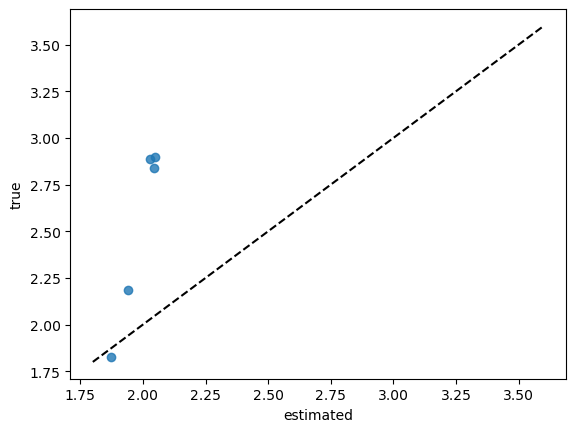

In [31]:
truemean_m = [np.mean(y) for _, y, _ in testseqs_list]
imputed_m = [np.mean(pred) for _, _, pred in testseqs_list]

plt.figure(figsize=(2, 2))
plt.scatter(imputed_m, truemean_m, alpha=0.8);
plt.plot([1.8, 3.6], [1.8, 3.6], '--k');
plt.xlabel('estimated');
plt.ylabel('true');

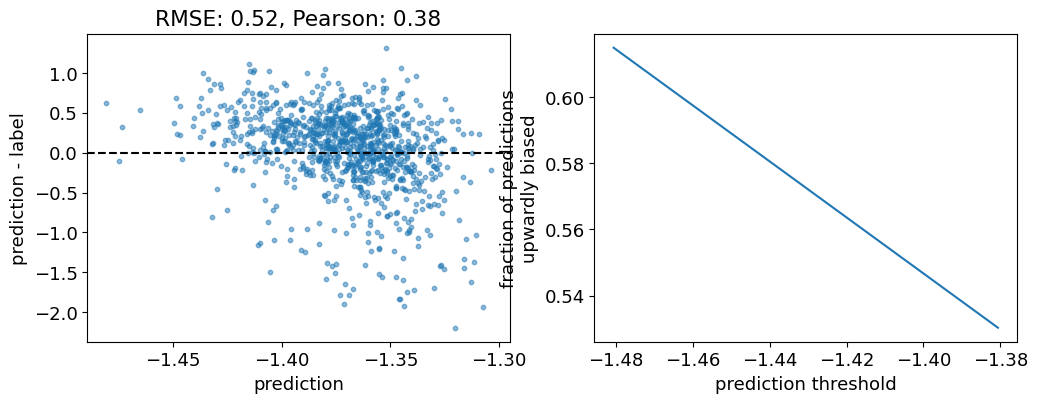

In [48]:
threshs = np.arange(np.min(predcal_n), np.max(predcal_n), 0.1)
res_n = predcal_n - ycal_n

rmse = np.sqrt(np.mean(np.square(predcal_n - ycal_n)))
r, p = sc.stats.pearsonr(predcal_n, ycal_n)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(predcal_n, res_n, s=10, alpha=0.5);
plt.axhline(0, linestyle='--', color='k');
plt.ylabel('prediction - label'); plt.xlabel('prediction');
plt.title('RMSE: {:.2f}, Pearson: {:.2f}'.format(rmse, r))

frac_up_bias = [np.mean(res_n[np.where(predcal_n >= thresh)[0]] > 0) for thresh in threshs]
plt.subplot(122)
plt.plot(threshs, frac_up_bias);
plt.xlabel('prediction threshold');
plt.ylabel('fraction of predictions\nupwardly biased');

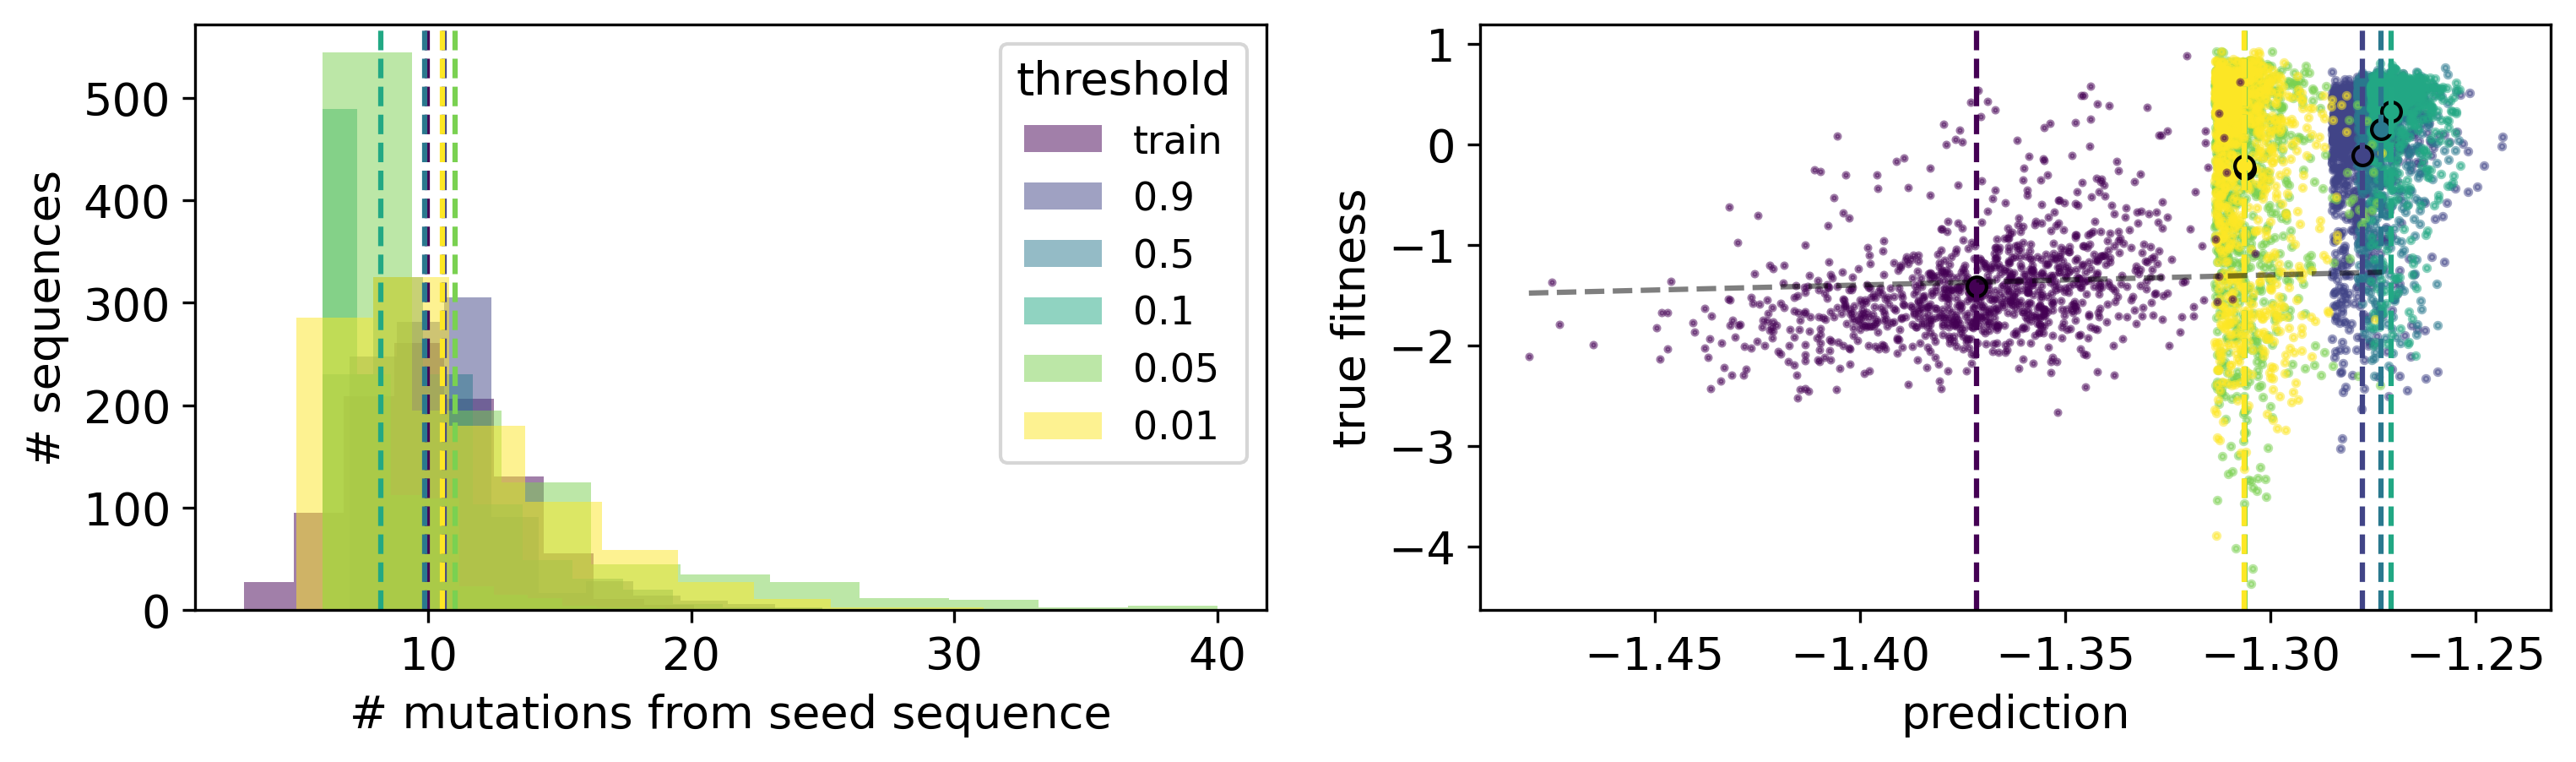

In [49]:
scatter_y_lim = [0.5, 4.5]
diag_line_lim = [np.min(predcal_n), np.max(testseqs_list[-1][2])]
font = {'size' : 13}
matplotlib.rc('font', **font)
scatter_s = 3
cmap = matplotlib.colormaps['viridis']
disttrain_n = np.array([editdistance.eval(factory.seed, s) for s in trainseqs_n])

plt.figure(figsize=(12, 3), dpi=300)

plt.subplot(121)
plt.hist(disttrain_n, alpha=0.5, label='train', color=cmap(0));
plt.axvline(np.mean(disttrain_n), alpha=1, linestyle='--', color=cmap(0))
plt.xlabel('# mutations from seed sequence');
plt.ylabel('# sequences');


for i, (testseqs_n, ytest_n, predtest_n) in enumerate(testseqs_list):
    testseqs_n, ytest_n, predtest_n = testseqs_list[i]
    color = cmap((i + 1) / len(hp_vals))
    plt.subplot(121)
    disttest_n = np.array([editdistance.eval(factory.seed, s) for s in testseqs_n])
    plt.hist(disttest_n, alpha=0.5, label=hp_vals[i], color=color);
    plt.axvline(np.mean(disttest_n), linestyle='--', color=color)

    plt.subplot(122)
    plt.scatter(predtest_n, ytest_n, alpha=0.5, s=scatter_s, color=color);
    plt.axvline(np.mean(predtest_n), alpha=1, linestyle='--', color=color);

for i, (testseqs_n, ytest_n, predtest_n) in enumerate(testseqs_list):
    plt.subplot(122)
    color = cmap((i + 1) / len(hp_vals))
    plt.scatter(np.mean(predtest_n), np.mean(ytest_n), color=color, alpha=1, s=30, edgecolor='k');

plt.subplot(121)
plt.legend(title=hp_name, fontsize=11);

plt.subplot(122)
plt.scatter(predcal_n, ycal_n, alpha=0.5, s=2, label='validation', color=cmap(0));
plt.scatter(np.mean(predcal_n), np.mean(ycal_n), color=cmap(0), alpha=1, s=30, edgecolor='k');
plt.plot(diag_line_lim, diag_line_lim, '--k', alpha=0.5);
plt.axvline(np.mean(predcal_n), alpha=1, linestyle='--', color=cmap(0))

# plt.xlim(scatter_lim);
# plt.ylim(scatter_y_lim);
plt.ylabel('true fitness');
plt.xlabel('prediction');




In [11]:
reload(dd)
X_mxNxd, y_mxN, pred_mxN, Xtrcal_nxd = dd.process_getted_data(
    trainseqs_n, calseqs_n, testseqs_list, s_utils.AAS
)

In [12]:
# TDRE
n_hidden = 256
config = {
    'waymark_type': 'mixed_dimensions',  # dummy value
    'val_frac': 0.1,
    'n_steps': 1000,
    'lr': 1e-3,
    'use_weighted_loss': True,
    'kd_bandwidth': 0.2
}
dre = tdre.TelescopingLogDensityRatioEstimator(
    None,
    238 * len(s_utils.AAS),
    n_ratio=len(hp_vals),
    n_waymarks_for_last_hp=0,
    device=torch.device('cuda'),
    dtype=torch.float,
    n_hidden=n_hidden,
    shared=False,
    multiclass=True,
    cranmer=False,
)

train_dfs = dre.fit(config, X_m1xnxd=X_mxNxd, Xm_nxp=Xtrcal_nxd)

X_m1xnxd is shape (7, 5000, 4760), Xm_nxp is shape (10000, 4760). 7 waymarks provided


100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.06it/s]


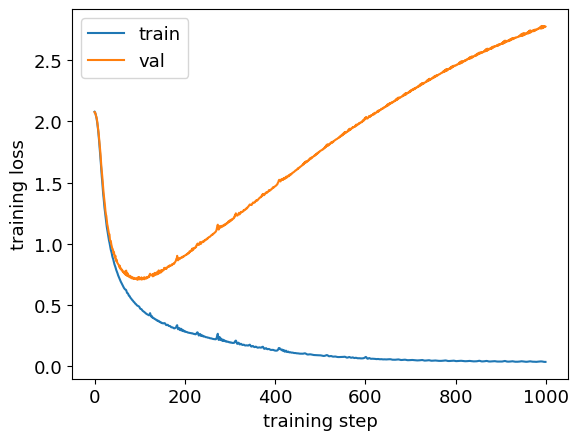

In [13]:
plt.plot(train_dfs['train_loss'], label='train')
plt.plot(train_dfs['val_loss'], label='val')
plt.xlabel('training step');
plt.ylabel('training loss'); 
plt.legend();

In [77]:
threshold = gfp_landscape.get_fitness([factory.seed])[0]

True means           :1.967 2.131 2.734 3.117 3.287 3.303 3.247 
Imputed means        :2.120 2.170 2.880 3.540 4.068 4.030 4.034 
PP multiclass        :3.653 3.660 4.361 5.073 5.602 3.497 5.567 


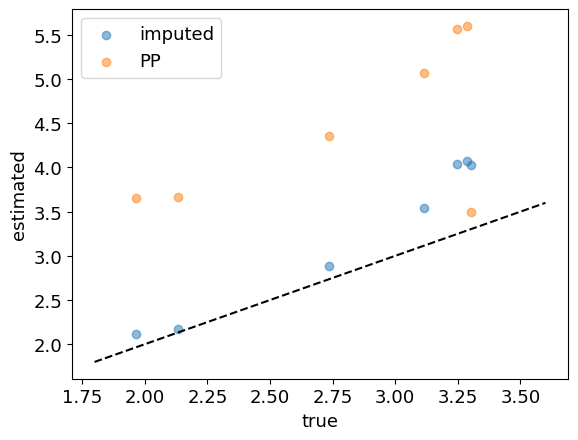

In [14]:
format_str = ''.join(['{}'] + len(hp_vals) * ['{:.3f} '])
truemean_m = np.mean(y_mxN, axis=1)
    
# imputation point estimates
imputed_m = np.mean(pred_mxN, axis=1)

# PP point estimates
Xcal_nxd = np.array([s_utils.string_to_one_hot(seq, s_utils.AAS).flatten() for seq in calseqs_n])
ppb_m, drb_nxm = dre.forecast_meany_per_bridge(
    Xcal_nxd, ycal_n, cranmer=False, self_normalized=True,
    predm_n=predcal_n, pred0_mxn=pred_mxN
)
print(format_str.format('True means           :', *truemean_m))
print(format_str.format('Imputed means        :', *imputed_m))
print(format_str.format('PP multiclass        :', *ppb_m))
plt.scatter(truemean_m, imputed_m, alpha=0.5);
plt.scatter(truemean_m, ppb_m, alpha=0.5);
plt.plot([1.8, 3.6], [1.8, 3.6], '--k');
plt.legend(['imputed', 'PP']);
plt.xlabel('true');
plt.ylabel('estimated');

# ESM

In [83]:
esm_model, esm_alphabet = torch.hub.load("facebookresearch/esm:main", "esm1v_t33_650M_UR90S_1")

Using cache found in /homefs/home/wongfanc/.cache/torch/hub/facebookresearch_esm_main
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1v_t33_650M_UR90S_1.pt" to /homefs/home/wongfanc/.cache/torch/hub/checkpoints/esm1v_t33_650M_UR90S_1.pt
/homefs/home/wongfanc/.cache/torch/hub/facebookresearch_esm_main/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [7]:
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

data = [
    ('trainseq{}'.format(i), seq) for i, seq in enumerate(trainseqs_n[: 100])
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=True)
token_representations = results["representations"][6]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

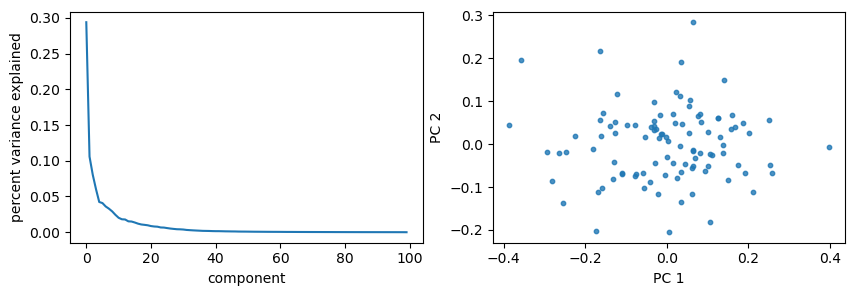

In [26]:
x_nxp = np.vstack([x.numpy()[None, :] for x in sequence_representations])
pca = PCA()
rep_nxp = pca.fit_transform(x_nxp)

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(pca.explained_variance_ratio_);
plt.ylabel('percent variance explained');
plt.xlabel('component')
plt.subplot(122)
plt.scatter(rep_nxp[:, 0], rep_nxp[:, 1], alpha=0.8, s=10);
plt.xlabel('PC 1');
plt.ylabel('PC 2');

In [49]:
batch_converter = esm_alphabet.get_batch_converter()
esm_model.eval()

data = [('seq{}'.format(i), seq) for i, seq in enumerate(trainseqs_n[: 5])]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != esm_alphabet.padding_idx).sum(1)

In [84]:
def get_esm_representations(seq_n, esm_model, esm_alphabet, batch_size: int = 200, layer: int = 33):
    batch_converter = esm_alphabet.get_batch_converter()
    esm_model.eval()

    data = [('seq{}'.format(i), seq) for i, seq in enumerate(seq_n)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_lens = (batch_tokens != esm_alphabet.padding_idx).sum(1)
    
    x_nxp = []
    n_batch = int(np.ceil(len(seq_n) / batch_size))
    for b in range(n_batch):

        # Extract per-residue representations (on CPU)
        with torch.no_grad():
            results = esm_model(
                batch_tokens[b * batch_size : (b + 1) * batch_size],
                repr_layers=[layer],
                return_contacts=True
            )
        token_representations = results["representations"][layer]

        # Generate per-sequence representations via averaging
        # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
        sequence_representations = []
        for i, tokens_len in enumerate(batch_lens[b * batch_size : (b + 1) * batch_size]):
            sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))
        x_nxp = x_nxp + [x.numpy()[None, :] for x in sequence_representations]
    x_nxp = np.vstack(x_nxp)
        
    return x_nxp

In [87]:
n_plot = 5000
batch_size = 100
layer = 33

thresh2rep = {}
t0 = time()
for i, (testseqs_n, ytest_n, predtest_n) in enumerate(testseqs_list):
    rep_nxp = get_esm_representations(
        testseqs_n[: n_plot], esm_model, esm_alphabet, batch_size=batch_size, layer=layer
    )
    thresh2rep[hp_vals[i]] = rep_nxp
    print('done with {} / {} ({} s)'.format(i, len(testseqs_list), int(time() - t0)))
allrep_xp = np.vstack([v for v in thresh2rep.values()])

# training sequences
trainrep_nxp = get_esm_representations(
    trainseqs_n[: n_plot], esm_model, esm_alphabet, batch_size=batch_size, layer=layer
)
allrep_xp = np.vstack([trainrep_nxp, allrep_xp])


KeyboardInterrupt



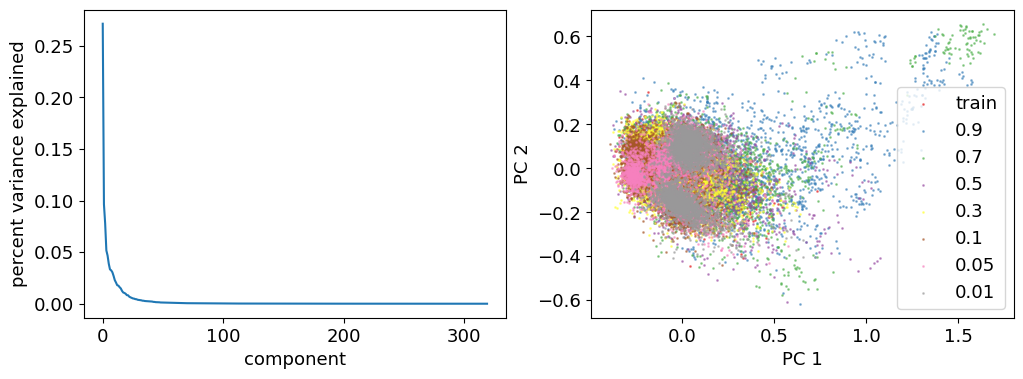

In [70]:
cmap = matplotlib.colormaps['Set1']
plt.figure(figsize=(12, 4))

pca = PCA()
pca.fit(allrep_xp)

plt.subplot(121)
plt.plot(pca.explained_variance_ratio_);
plt.ylabel('percent variance explained');
plt.xlabel('component')

# train
pc_nxp = pca.transform(trainrep_nxp)

plt.subplot(122)
plt.scatter(pc_nxp[:, 0], pc_nxp[:, 1], color=cmap(0), s=1, alpha=0.5, label='train')

for i, (hp_val, x_nxp) in enumerate(thresh2rep.items()):
    color = cmap((i + 1) / len(hp_vals))
    pc_nxp = pca.transform(x_nxp)
    plt.scatter(pc_nxp[:, 0], pc_nxp[:, 1], color=color, s=1, alpha=0.5, label=hp_val)

plt.legend()
plt.xlabel('PC 1');
plt.ylabel('PC 2');

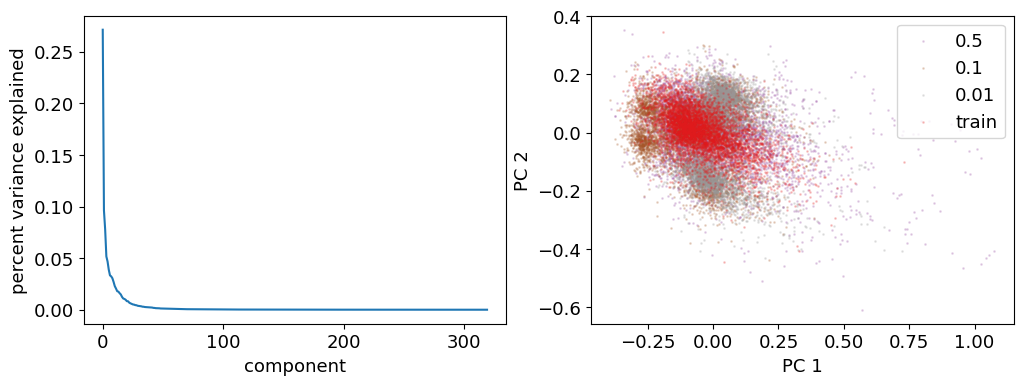

In [257]:
cmap = matplotlib.colormaps['Set1']
plt.figure(figsize=(12, 4))

pca = PCA()
pca.fit(allrep_xp)

plt.subplot(121)
plt.plot(pca.explained_variance_ratio_);
plt.ylabel('percent variance explained');
plt.xlabel('component')

plt.subplot(122)

for i, (hp_val, x_nxp) in enumerate(esm2_thresh2rep.items()):
    if i in [2, 4, 6]:
        color = cmap((i + 1) / len(hp_vals))
        pc_nxp = pca.transform(x_nxp)
        plt.scatter(pc_nxp[:, 0], pc_nxp[:, 1], color=color, s=1, alpha=0.2, label=hp_val)
        
# train
pc_nxp = pca.transform(esm2_trainrep_nxp)
plt.scatter(pc_nxp[:, 0], pc_nxp[:, 1], color=cmap(0), s=1, alpha=0.2, label='train')

plt.legend()
plt.xlabel('PC 1');
plt.ylabel('PC 2');

In [86]:
# esm2_thresh2rep = copy.deepcopy(thresh2rep)
# esm2_trainrep_nxp = trainrep_nxp.copy()

# predictive model last layer

In [ ]:
from keras import backend as K

In [71]:
rep_mxNxd = np.stack([thresh2rep[hp_val] for hp_val in hp_vals], axis=0)
print(rep_mxNxd.shape)
reptrcal_nxd = trainrep_nxp.copy()
print(reptrcal_nxd.shape)

(7, 5000, 320)
(5000, 320)


In [142]:
Xtr_nxp = np.stack([s_utils.string_to_one_hot(seq, s_utils.AAS) for seq in trainseqs_n])
Xtest_nxp_list = []
for testseq_n, _, _ in testseqs_list:
    Xtest_nxp = np.stack([s_utils.string_to_one_hot(seq, s_utils.AAS) for seq in testseq_n])
    Xtest_nxp_list.append(Xtest_nxp)
# print(Xtr_nxp.shape, Xtest_nxp.shape)

In [136]:
factory.explorer.model.models[0].model.layers

In [233]:
layer_idx = 4

inp = factory.explorer.model.models[0].model.input                                       # input placeholder
outputs = [layer.output for layer in factory.explorer.model.models[0].model.layers]          # all layer outputs
functor = K.function([inp], outputs)   # evaluation function

# test = np.random.random((1, 238, len(s_utils.AAS)))
reptr_nxp = functor([Xtr_nxp])[layer_idx]
print(reptr_nxp.shape)
reptest_nxp_list = []
for Xtest_nxp in Xtest_nxp_list:
    reptest_nxp = functor([Xtest_nxp])[layer_idx]
    reptest_nxp_list.append(reptest_nxp)

(5000, 64)


In [145]:
pca.explained_variance_ratio_

array([9.64816034e-01, 7.85001367e-03, 4.26206272e-03, 3.85273201e-03,
       3.22544505e-03, 2.31862068e-03, 2.17605196e-03, 1.97057449e-03,
       1.45828177e-03, 1.22219161e-03, 1.13342132e-03, 8.30637407e-04,
       7.68079073e-04, 6.55424665e-04, 5.88129857e-04, 4.82682080e-04,
       3.52456438e-04, 3.15200276e-04, 2.73612939e-04, 2.29524099e-04,
       2.02553390e-04, 1.41730052e-04, 1.16076517e-04, 1.06827909e-04,
       9.97963070e-05, 8.07060205e-05, 7.07618528e-05, 5.09535967e-05,
       4.89228842e-05, 4.07303341e-05, 2.92141449e-05, 2.76532974e-05,
       2.43087761e-05, 2.27730579e-05, 1.59279662e-05, 1.50314090e-05,
       1.44753130e-05, 1.34390521e-05, 1.09258981e-05, 1.00342986e-05,
       9.65847812e-06, 9.31983323e-06, 8.77497587e-06, 7.98734891e-06,
       7.43797500e-06, 6.22258403e-06, 5.38766426e-06, 4.64018694e-06,
       4.34755520e-06, 3.86014153e-06, 2.64975688e-06, 1.43642478e-06,
       1.31065269e-06, 1.21028711e-06, 1.01220121e-06, 6.68951657e-07,
      

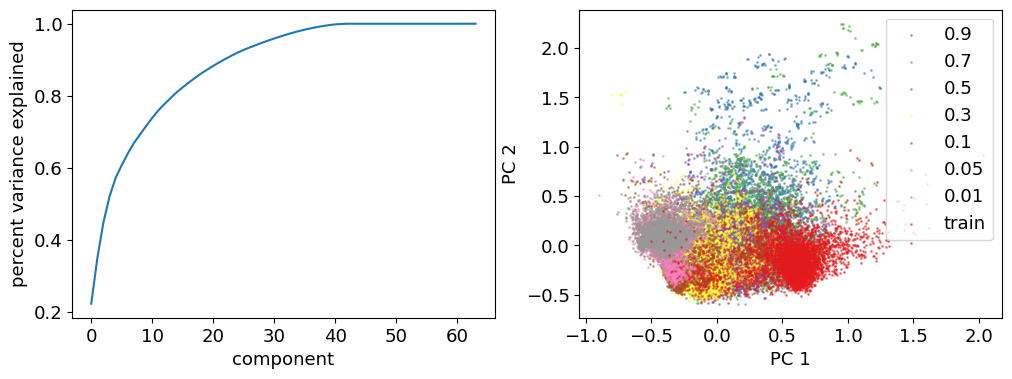

In [235]:
cmap = matplotlib.colormaps['Set1']
plt.figure(figsize=(12, 4))

pca = PCA()
pca.fit(np.vstack([reptr_nxp] + reptest_nxp_list))

plt.subplot(121)
plt.plot(np.cumsum(pca.explained_variance_ratio_));
plt.ylabel('percent variance explained');
plt.xlabel('component')

plt.subplot(122)


for i, reptest_nxp in enumerate(reptest_nxp_list):
    color = cmap((i + 1) / len(hp_vals))
    pctest_nxp = pca.transform(reptest_nxp)
    plt.scatter(pctest_nxp[:, 0], pctest_nxp[:, 1], color=color, s=1, alpha=0.5, label=hp_vals[i])

# train
pctr_nxp = pca.transform(reptr_nxp)
plt.scatter(pctr_nxp[:, 0], pctr_nxp[:, 1], color=cmap(0), s=1, alpha=0.5, label='train')
    

plt.legend()
plt.xlabel('PC 1');
plt.ylabel('PC 2');

/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'kde_kws'
  cset = contour_func(
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homefs/home/wongfanc/mi

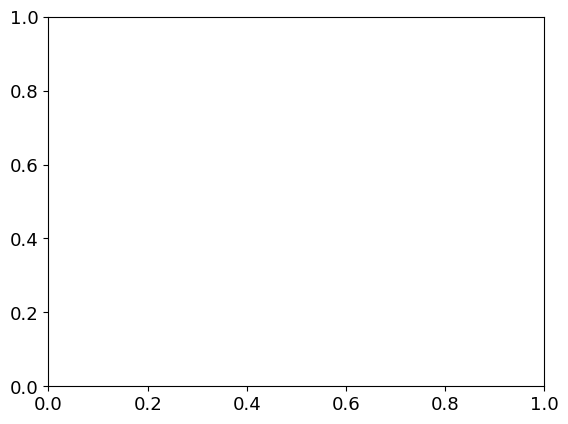

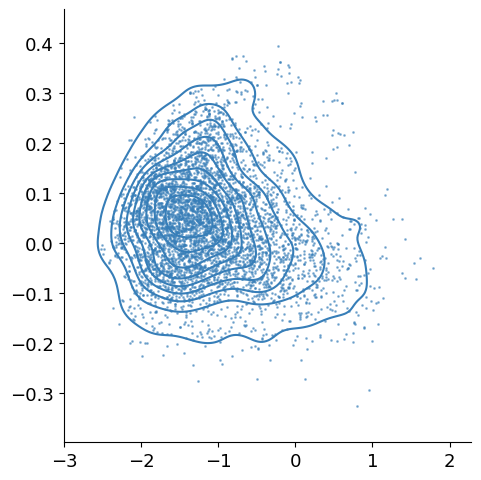

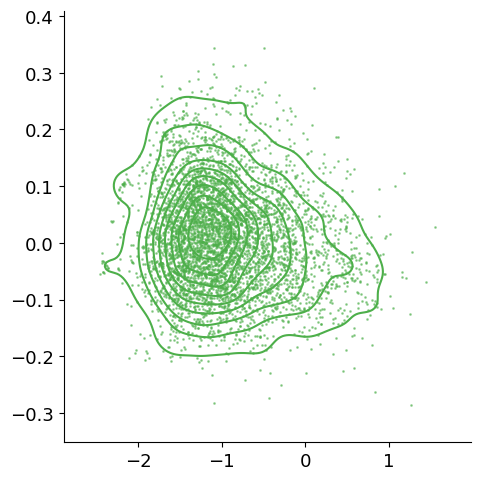

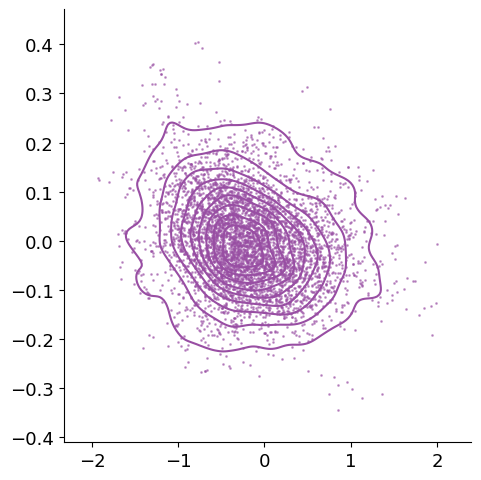

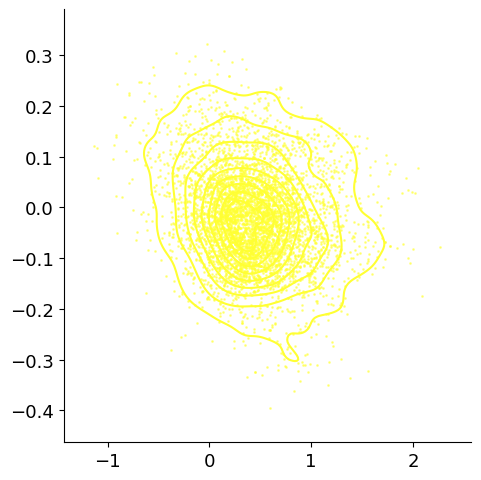

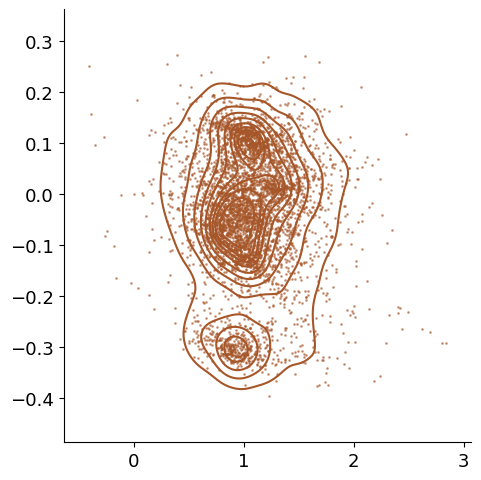

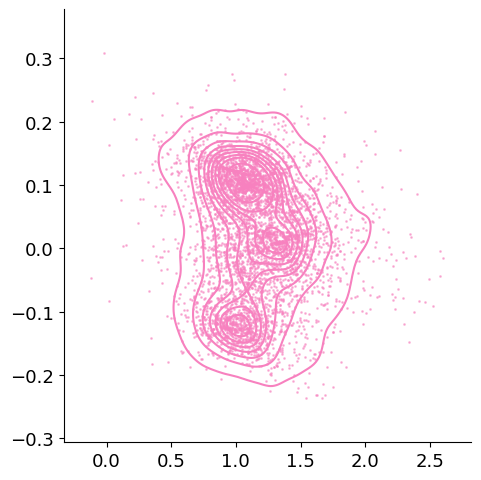

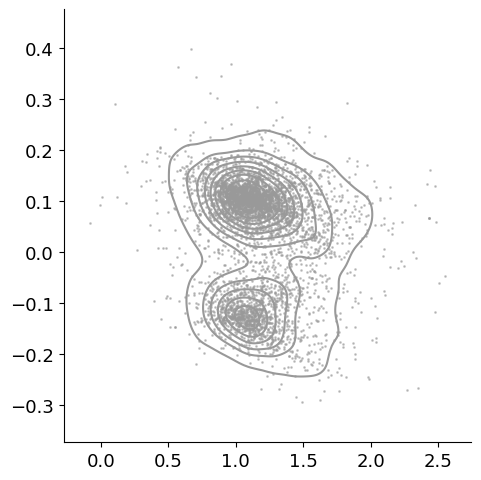

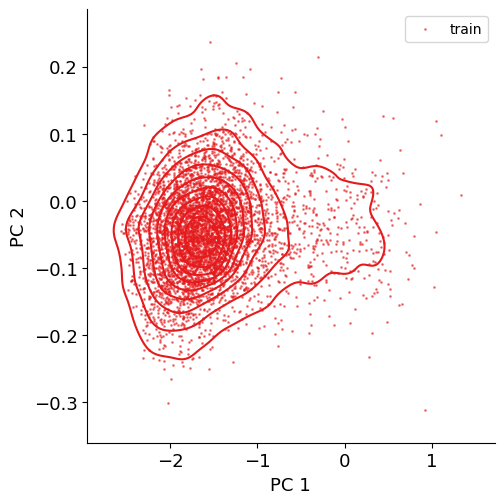

In [191]:
# KDE

# run KDE separately on top 2 PCs of each design distribution
# follow forecast_meany_per_bridge() code to get forecasts

pca = PCA()
pca.fit(np.vstack([reptr_nxp] + reptest_nxp_list))
kde = KernelDensity(bandwidth=0.5)

axs = plt.subplots(1, 1)

for i, reptest_nxp in enumerate(reptest_nxp_list):
    color = cmap((i + 1) / len(hp_vals))
    pctest_nxp = pca.transform(reptest_nxp)

    sns.displot(
        x=pctest_nxp[:, 0], y=pctest_nxp[:, 1], ax=axs[0], color=color,
        kind='kde', kde_kws={'bw': 10}
    )
    plt.scatter(pctest_nxp[:, 0], pctest_nxp[:, 1], color=color, s=1, alpha=0.5, label=hp_vals[i])

pctr_nxp = pca.transform(reptr_nxp)
sns.displot(x=pctr_nxp[:, 0], y=pctr_nxp[:, 1], ax=axs[0], color=cmap(0), kind='kde', kde_kws={'bw': 10})
plt.scatter(pctr_nxp[:, 0], pctr_nxp[:, 1], color=cmap(0), s=1, alpha=0.5, label='train');
plt.legend(fontsize=10)
plt.xlabel('PC 1');
plt.ylabel('PC 2');

In [213]:
Xcal_nxd = np.stack([s_utils.string_to_one_hot(seq, s_utils.AAS) for seq in calseqs_n], axis=0)
repcal_nxp = functor([Xcal_nxd])[6]
pccal_nxp = pca.transform(repcal_nxp)

In [228]:
bw = 2
hp_idx = 0
# ppb_m, drb_nxm = dre.forecast_meany_per_bridge(
#     repcal_nxp, ycal_n, cranmer=False, self_normalized=True,
#     predm_n=predcal_n, pred0_mxn=pred_mxN
# )

kde_tr = KernelDensity(bandwidth=bw)
kde_tr.fit(pctr_nxp[:, : 3])

reptest_nxp = reptest_nxp_list[hp_idx]
pctest_nxp = pca.transform(reptest_nxp)

kde_test = KernelDensity(bandwidth=bw)
kde_test.fit(pctest_nxp[:, : 3])

numll_n = kde_test.score_samples(pccal_nxp[:, : 3])
denomll_n = kde_tr.score_samples(pccal_nxp[:, : 3])
ldr_n = numll_n - denomll_n
# c = np.max(ldr_n)
# normalization = c + np.log(np.sum(np.exp(ldr_n - c)))
# normalizeddr_n = np.exp(ldr_n - normalization) * ldr_n.size
normalizeddr_n = np.exp(ldr_n)  # not normalized lol

weightedrect_n = normalizeddr_n * (predcal_n - ycal_n)
forecast = np.mean(pred_mxN[hp_idx]) - np.mean(weightedrect_n)

truemean_m = np.mean(y_mxN, axis=1)
imputed_m = np.mean(pred_mxN, axis=1)
print(truemean_m[hp_idx], imputed_m[hp_idx], forecast)

1.9666494471320533 2.120358236217499 2.122103732261287


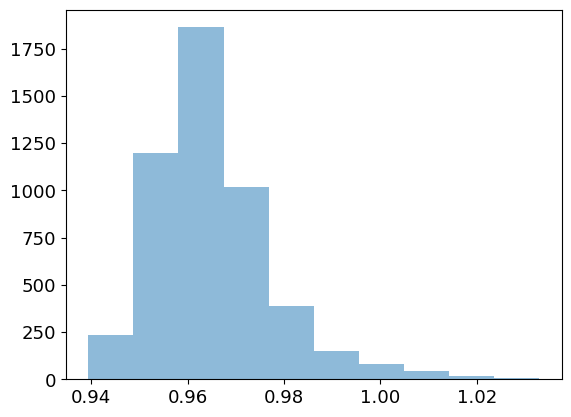

In [221]:
# plt.hist(numll_n, alpha=0.5);
# plt.hist(denomll_n, alpha=0.5);
plt.hist(normalizeddr_n, alpha=0.5);

In [252]:
n_pc = 40
pca = PCA()
pca.fit(np.vstack([reptr_nxp] + reptest_nxp_list))

rep_mxNxd = np.stack([pca.transform(reptest_nxp)[:, : n_pc] for reptest_nxp in reptest_nxp_list], axis=0)
print(rep_mxNxd.shape)
reptrcal_nxd = pca.transform(reptr_nxp)[:, : n_pc]
print(reptrcal_nxd.shape)



(7, 5000, 40)
(5000, 40)


In [247]:
rep_mxNxd = np.stack(reptest_nxp_list, axis=0)
print(rep_mxNxd.shape)
reptrcal_nxd = reptr_nxp.copy()
print(reptrcal_nxd.shape)

(7, 5000, 64)
(5000, 64)


In [253]:
# TDRE
n_hidden = 100
n_pc = 40
config = {
    'waymark_type': 'mixed_dimensions',  # dummy value
    'val_frac': 0.1,
    'n_steps': 3000,
    'lr': 1e-3,
    'use_weighted_loss': True,
    'kd_bandwidth': 0.2
}
dre = tdre.TelescopingLogDensityRatioEstimator(
    None,
    n_pc,
    n_ratio=len(hp_vals),
    n_waymarks_for_last_hp=0,
    device=torch.device('cuda'),
    dtype=torch.float,
    n_hidden=n_hidden,
    shared=False,
    multiclass=True,
    cranmer=False,
)

train_dfs = dre.fit(config, X_m1xnxd=rep_mxNxd[:, :, : n_pc], Xm_nxp=reptrcal_nxd[:, : n_pc])

X_m1xnxd is shape (7, 5000, 40), Xm_nxp is shape (5000, 40). 7 waymarks provided


100%|███████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:08<00:00, 374.93it/s]


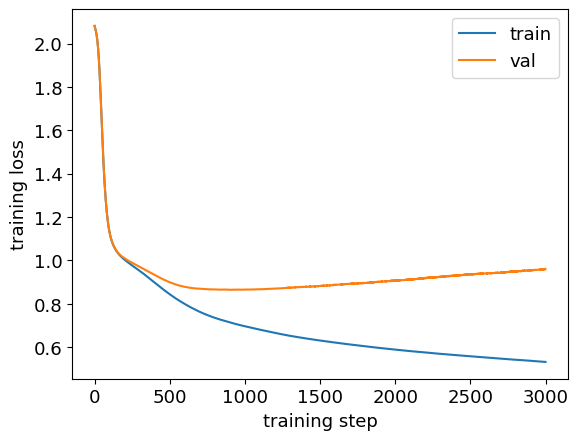

In [254]:
plt.plot(train_dfs['train_loss'], label='train')
plt.plot(train_dfs['val_loss'], label='val')
plt.xlabel('training step');
plt.ylabel('training loss'); 
plt.legend();

In [255]:
print('using layer_idx {}'.format(layer_idx))
Xcal_nxd = np.stack([s_utils.string_to_one_hot(seq, s_utils.AAS) for seq in calseqs_n], axis=0)

repcal_nxp = functor([Xcal_nxd])[layer_idx]
repcal_nxp = pca.transform(repcal_nxp)[:, : n_pc]
print(repcal_nxp.shape)
ppb_m, drb_nxm = dre.forecast_meany_per_bridge(
    repcal_nxp, ycal_n, cranmer=False, self_normalized=True,
    predm_n=predcal_n, pred0_mxn=pred_mxN
)

using layer_idx 4
(5000, 40)


True means           :1.967 2.131 2.734 3.117 3.287 3.303 3.247 
Imputed means        :2.120 2.170 2.880 3.540 4.068 4.030 4.034 
PP multiclass        :1.602 2.280 3.134 4.531 4.763 5.902 5.344 


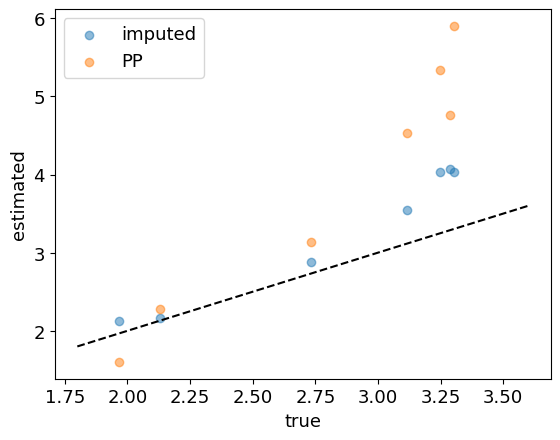

In [256]:
format_str = ''.join(['{}'] + len(hp_vals) * ['{:.3f} '])
truemean_m = np.mean(y_mxN, axis=1)
    
# imputation point estimates
imputed_m = np.mean(pred_mxN, axis=1)

print(format_str.format('True means           :', *truemean_m))
print(format_str.format('Imputed means        :', *imputed_m))
print(format_str.format('PP multiclass        :', *ppb_m))
plt.scatter(truemean_m, imputed_m, alpha=0.5);
plt.scatter(truemean_m, ppb_m, alpha=0.5);
plt.plot([1.8, 3.6], [1.8, 3.6], '--k');
plt.legend(['imputed', 'PP']);
plt.xlabel('true');
plt.ylabel('estimated');